# The building and tuning of an LSTM modell for predicting Stock Prices

In [1]:
# Importing necessary libraries

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

# Input Parameters for training
data_path = './VTI.csv'
# cv_size = 0.2
test_size = 0.2
validation_size = 0.2


N = 9 # amount of days we go back for prediction. Hyper parameter.
lstm_units = 50 # number of cells (memory blocks) in the lstm network
dropout_prob = 0.6
optimizer = 'adam'
epochs=1
batch_size=1

# fix random seed for reproducibility
seed(101)
tf.random.set_seed(100)

# Utility functions

In [2]:
# We need to split the datset into X samples and Y features.
# X will be the data windows starting from t-1..t-2...unti t-N. 
# Y is the data at t+1
def create_dataset(dataset, N=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-N-1):
        a = dataset[i:(i+N), 0]
        dataX.append(a)
        dataY.append(dataset[i + N, 0])
    return np.array(dataX), np.array(dataY)

# function for hioer parameter tuning
def train_pred_eval_model(x_train, \
                          y_train, \
                          scaler, \
                          lstm_units=50, \
                          dropout_prob=0.6, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1,\
                          ):
    
    # scale data
    # y_train = scaler.fit_transform(y_train)
    
    # Train, predict and eval model
    print("In function x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
    print("In function y_train.shape = " + str(y_train.shape)) # (446, 1)
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],N)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    #
    ## compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    ## train model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    
    # Do prediction
    train_predict = model.predict(x_train)

    # invert standardize data
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
    print('RMSE = %.2f RMSE' % (rmse))

    # Calculate MAPE
    mape = tf.keras.losses.mean_absolute_percentage_error(y_train[0], train_predict[:,0])
    print("MAPE = %0.3f%%" % (mape))

    return rmse, mape, train_predict


# Exploring the data

In [3]:
# Load data
df = pd.read_csv(data_path) 
# Sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)
df.describe()


High         Low        Open       Close        Volume  \
count  755.000000  755.000000  755.000000  755.000000  7.550000e+02   
mean   124.354344  123.288080  123.871762  123.857351  2.608427e+06   
std     15.339127   15.249342   15.303200   15.270251  1.432485e+06   
min     93.059998   91.580002   92.389999   92.559998  5.524000e+05   
25%    110.949997  109.969997  110.485001  110.474998  1.749250e+06   
50%    124.089996  123.480003  123.900002  123.849998  2.192600e+06   
75%    138.529999  137.089996  137.764999  137.684998  2.968450e+06   
max    151.839996  151.050003  151.820007  151.309998  1.384490e+07   

        Adj Close  
count  755.000000  
mean   115.440174  
std     16.015447  
min     83.969048  
25%    101.368549  
50%    115.197754  
75%    130.027611  
max    143.833847

# Plot data

Text(0, 0.5, 'USD')

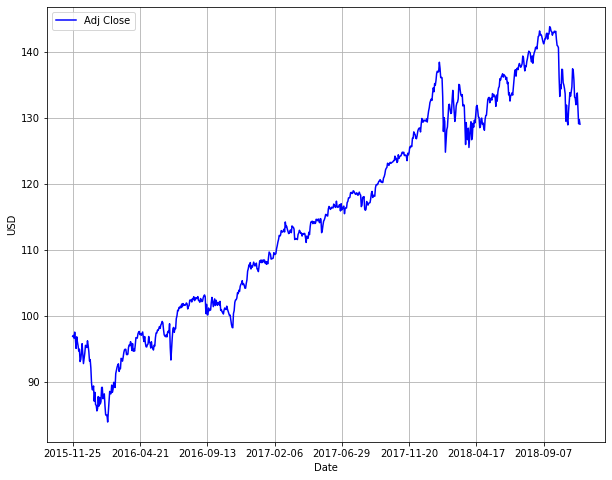

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("USD")

# Split data into Train and Test

In [5]:
# Date column is not needed. 
adj_close = pd.read_csv(data_path, usecols=[6], engine='python')
dataset = adj_close.values # converts to numpy array for easier transformations
dataset = dataset.astype('float32') # keras LSTM works better with floats

# Standardize data
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)
# Get sizes of each of the datasets
num_test = int(len(df)*test_size) # 20% of the data
num_train = len(df) - num_test

print("num_train = " + str(num_train))
print("num_test = " + str(num_test))

# Split into train and test data
train = dataset[0:num_train,:]
test = dataset[num_train:,:]

print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

num_train = 604
num_test = 151
train.shape = (604, 1)
test.shape = (151, 1)


# Rescaling data and creating X and Y from the input data

In [6]:
# Converting dataset into x_train and y_train
# Only training dataset is scaled, and not the entire dataset to prevent information leak
#scaler = StandardScaler() # calculates (x-u)/s for each element

# Scaling Train data
# train = scaler.fit_transform(train) #reshape(-1,1) because we only have one feature

# Split into X samples and Y features
x_train, y_train = create_dataset(train, N)

# Reshape for LSTM input format: [samples, time-steps, features]
x_train = np.reshape(x_train,(x_train.shape[0], 1 , x_train.shape[1]))
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)


x_train.shape = (594, 1, 9)
y_train.shape = (594,)


In [7]:
# Scaling Test data
#test = scaler.fit_transform(test) #reshape(-1,1) because we only have one feature

# Split into X samples and Y features
x_test, y_test = create_dataset(test, N)

# Reshape for LSTM input format: [samples, time-steps, features]
x_test = np.reshape(x_test,(x_test.shape[0], 1 , x_test.shape[1]))
print("x_test.shape = " + str(x_test.shape)) # (446, 7, 1)
print("y_test.shape = " + str(y_test.shape)) # (446, 1)

x_test.shape = (141, 1, 9)
y_test.shape = (141,)


# Configure and train the LSTM Network

In [8]:
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],N)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))
#
## compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)
## train model
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
## save model
model.save('asm_lstm.h5')


594/594 - 1s - loss: 0.1755


# Model Summary

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             12000     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Plot and save model
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Do prediction

In [11]:
# Do prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# est = inverse transform
#print("est.shape = " + str(est.shape))

# invert standardize data
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('RMSE = %.2f RMSE' % (trainScore))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100
print("MAPE = %0.3f%%" % mape)

RMSE = 1.90 RMSE
MAPE = 1.284%


# Plot basline and predictions

In [12]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# shift train data for plotting
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:,:] = np.nan
train_predict_plot[N:len(train_predict)+N,:] = train_predict

# shift test data for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+(N*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()


# Hyperparameter tunning for N

In [13]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train, y_train = create_dataset(train, param)
    
    # Reshape data
    x_train = np.reshape(x_train,(x_train.shape[0], 1 , x_train.shape[1]))
    
    # Train, predict and eval model
    #rmse, mape = train_pred_eval_model(x_train, \
    #                                      y_train, \
     #                                     scaler, \
      #                                    lstm_units=lstm_units, \
       #                                   dropout_prob=dropout_prob, \
        #                                  optimizer=optimizer, \
         #                                 epochs=epochs, \
          #                                batch_size=batch_size)
    
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],param)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    #
    ## compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    ## train model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    
    # predict
    # Do prediction
    train_predict = model.predict(x_train)
    # est = inverse transform
    #print("est.shape = " + str(est.shape))

    # invert standardize data
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
    # print('RMSE = %.2f RMSE' % (trainScore))

    #from sklearn.metrics import mean_absolute_percentage_error
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100
    # print("MAPE = %0.3f%%" % mape)
    
    # Collect results
    
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-13-f5a02c47c592>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/57 [00:00<?, ?it/s]

600/600 - 1s - loss: 0.2061
599/599 - 1s - loss: 0.1829
598/598 - 1s - loss: 0.1626
597/597 - 1s - loss: 0.1521
596/596 - 1s - loss: 0.1760
595/595 - 1s - loss: 0.1602
594/594 - 1s - loss: 0.1828
593/593 - 1s - loss: 0.1415
592/592 - 1s - loss: 0.1416
591/591 - 1s - loss: 0.1745
590/590 - 1s - loss: 0.1467
589/589 - 1s - loss: 0.1768
588/588 - 1s - loss: 0.1725
587/587 - 1s - loss: 0.1576
586/586 - 1s - loss: 0.1584
585/585 - 1s - loss: 0.1315
584/584 - 1s - loss: 0.1494
583/583 - 1s - loss: 0.1442
582/582 - 1s - loss: 0.1687
581/581 - 1s - loss: 0.1567
580/580 - 1s - loss: 0.1677
579/579 - 1s - loss: 0.1784
578/578 - 1s - loss: 0.1439
577/577 - 1s - loss: 0.1416
576/576 - 1s - loss: 0.1501
575/575 - 1s - loss: 0.1416
574/574 - 1s - loss: 0.1848
573/573 - 1s - loss: 0.1699
572/572 - 1s - loss: 0.1530
571/571 - 1s - loss: 0.1761
570/570 - 1s - loss: 0.1548
569/569 - 1s - loss: 0.1542
568/568 - 1s - loss: 0.1381
567/567 - 1s - loss: 0.1611
566/566 - 1s - loss: 0.1363
565/565 - 1s - loss:

N      rmse  mape_pct
0    3  1.643081  1.179921
1    4  2.413342  1.795722
2    5  2.054153  1.326264
3    6  1.698396  1.133611
4    7  2.008767  1.414175
5    8  2.064254  1.305452
6    9  1.863418  1.343097
7   10  1.909861  1.301831
8   11  2.100974  1.583801
9   12  2.218761  1.442503
10  13  2.153350  1.458900
11  14  2.223378  1.447211
12  15  2.383391  1.536990
13  16  3.128391  2.071389
14  17  3.431330  2.506583
15  18  2.883227  1.912454
16  19  2.910906  1.920734
17  20  2.567923  1.561911
18  21  2.539404  1.784421
19  22  2.537695  1.641175
20  23  2.906127  1.787980
21  24  2.828346  1.878083
22  25  3.438072  2.381386
23  26  2.266716  1.540252
24  27  2.570751  1.791026
25  28  2.434343  1.619539
26  29  2.692359  1.706088
27  30  3.362680  2.164297
28  31  2.747573  1.789951
29  32  3.429676  2.369466
30  33  2.236993  1.463576
31  34  2.483082  1.605907
32  35  3.494333  2.331417
33  36  2.885435  2.138815
34  37  2.569973  1.755298
35  38  2.575166  1.674274
36  39  2.686710  1.830298
37  40  2.220222  1.418413
38  41  2.117264  1.365089
39  42  2.485497  1.796819
40  43  3.428509  2.405720
41  44  2.603971  1.843239
42  45  2.395079  1.558579
43  46  2.382478  1.547747
44  47  5.169617  3.944403
45  48  2.935214  1.803909
46  49  2.817141  1.970501
47  50  2.222192  1.459993
48  51  2.704066  1.874780
49  52  2.297242  1.592748
50  53  2.214231  1.486789
51  54  2.192185  1.495343
52  55  3.051797  2.109263
53  56  3.501630  2.567624
54  57  2.391367  1.645895
55  58  2.178009  1.446969
56  59  2.380237  1.602582

In [14]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

Text(0, 0.5, 'RMSE/MAPE(%)')

In [15]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 1.643
min MAPE = 1.134%
optimum N = 3


# Hyperparameter tuning for epochs and batch_size

In [16]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()

# Split train into x and y
x_train, y_train = create_dataset(train, N_opt)
    
# Reshape data
x_train = np.reshape(x_train,(x_train.shape[0], 1 , x_train.shape[1]))

for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
        
        # Train, predict and eval model
        model = Sequential()
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],3)))
        model.add(Dropout(dropout_prob))
        model.add(LSTM(units=lstm_units))
        model.add(Dropout(dropout_prob))
        model.add(Dense(1))
        #
        ## compile model
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        ## train model
        model.fit(x_train, y_train, epochs=param, batch_size=param2, verbose=2)
    
        # predict
        # Do prediction
        train_predict = model.predict(x_train)
        # est = inverse transform
        #print("est.shape = " + str(est.shape))

        # invert standardize data
        train_predict = scaler.inverse_transform(train_predict)
        y_train_orig = scaler.inverse_transform([y_train])
    
        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(y_train_orig[0], train_predict[:,0]))
        # print('RMSE = %.2f RMSE' % (trainScore))

        #from sklearn.metrics import mean_absolute_percentage_error
        # Calculate MAPE
        mape = mean_absolute_percentage_error(y_train_orig[0], train_predict[:,0])*100
        # print("MAPE = %0.3f%%" % mape)
    
        # Collect results
    
       # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-16-99ddc4e8ba7d>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-16-99ddc4e8ba7d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

75/75 - 0s - loss: 0.5279
38/38 - 0s - loss: 0.6283
19/19 - 0s - loss: 0.7329
10/10 - 0s - loss: 0.7674
5/5 - 0s - loss: 0.7731


<ipython-input-16-99ddc4e8ba7d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
75/75 - 0s - loss: 0.5496
Epoch 2/10
75/75 - 0s - loss: 0.1042
Epoch 3/10
75/75 - 0s - loss: 0.0646
Epoch 4/10
75/75 - 0s - loss: 0.0468
Epoch 5/10
75/75 - 0s - loss: 0.0639
Epoch 6/10
75/75 - 0s - loss: 0.0428
Epoch 7/10
75/75 - 0s - loss: 0.0485
Epoch 8/10
75/75 - 0s - loss: 0.0549
Epoch 9/10
75/75 - 0s - loss: 0.0481
Epoch 10/10
75/75 - 0s - loss: 0.0498
Epoch 1/10
38/38 - 0s - loss: 0.6371
Epoch 2/10
38/38 - 0s - loss: 0.2366
Epoch 3/10
38/38 - 0s - loss: 0.0978
Epoch 4/10
38/38 - 0s - loss: 0.0586
Epoch 5/10
38/38 - 0s - loss: 0.0562
Epoch 6/10
38/38 - 0s - loss: 0.0574
Epoch 7/10
38/38 - 0s - loss: 0.0490
Epoch 8/10
38/38 - 0s - loss: 0.0575
Epoch 9/10
38/38 - 0s - loss: 0.0450
Epoch 10/10
38/38 - 0s - loss: 0.0497
Epoch 1/10
19/19 - 0s - loss: 0.7097
Epoch 2/10
19/19 - 0s - loss: 0.5149
Epoch 3/10
19/19 - 0s - loss: 0.2700
Epoch 4/10
19/19 - 0s - loss: 0.1430
Epoch 5/10
19/19 - 0s - loss: 0.1080
Epoch 6/10
19/19 - 0s - loss: 0.0766
Epoch 7/10
19/19 - 0s - loss: 0.0545

<ipython-input-16-99ddc4e8ba7d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
75/75 - 0s - loss: 0.5791
Epoch 2/20
75/75 - 0s - loss: 0.1104
Epoch 3/20
75/75 - 0s - loss: 0.0665
Epoch 4/20
75/75 - 0s - loss: 0.0455
Epoch 5/20
75/75 - 0s - loss: 0.0623
Epoch 6/20
75/75 - 0s - loss: 0.0422
Epoch 7/20
75/75 - 0s - loss: 0.0459
Epoch 8/20
75/75 - 0s - loss: 0.0532
Epoch 9/20
75/75 - 0s - loss: 0.0491
Epoch 10/20
75/75 - 0s - loss: 0.0522
Epoch 11/20
75/75 - 0s - loss: 0.0439
Epoch 12/20
75/75 - 0s - loss: 0.0461
Epoch 13/20
75/75 - 0s - loss: 0.0434
Epoch 14/20
75/75 - 0s - loss: 0.0488
Epoch 15/20
75/75 - 0s - loss: 0.0451
Epoch 16/20
75/75 - 0s - loss: 0.0435
Epoch 17/20
75/75 - 0s - loss: 0.0455
Epoch 18/20
75/75 - 0s - loss: 0.0419
Epoch 19/20
75/75 - 0s - loss: 0.0479
Epoch 20/20
75/75 - 0s - loss: 0.0409
Epoch 1/20
38/38 - 0s - loss: 0.6522
Epoch 2/20
38/38 - 0s - loss: 0.2565
Epoch 3/20
38/38 - 0s - loss: 0.1067
Epoch 4/20
38/38 - 0s - loss: 0.0652
Epoch 5/20
38/38 - 0s - loss: 0.0611
Epoch 6/20
38/38 - 0s - loss: 0.0578
Epoch 7/20
38/38 - 0s - los

<ipython-input-16-99ddc4e8ba7d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/30
75/75 - 0s - loss: 0.5302
Epoch 2/30
75/75 - 0s - loss: 0.0907
Epoch 3/30
75/75 - 0s - loss: 0.0678
Epoch 4/30
75/75 - 0s - loss: 0.0504
Epoch 5/30
75/75 - 0s - loss: 0.0622
Epoch 6/30
75/75 - 0s - loss: 0.0455
Epoch 7/30
75/75 - 0s - loss: 0.0446
Epoch 8/30
75/75 - 0s - loss: 0.0519
Epoch 9/30
75/75 - 0s - loss: 0.0496
Epoch 10/30
75/75 - 0s - loss: 0.0516
Epoch 11/30
75/75 - 0s - loss: 0.0465
Epoch 12/30
75/75 - 0s - loss: 0.0472
Epoch 13/30
75/75 - 0s - loss: 0.0451
Epoch 14/30
75/75 - 0s - loss: 0.0499
Epoch 15/30
75/75 - 0s - loss: 0.0460
Epoch 16/30
75/75 - 0s - loss: 0.0429
Epoch 17/30
75/75 - 0s - loss: 0.0470
Epoch 18/30
75/75 - 0s - loss: 0.0420
Epoch 19/30
75/75 - 0s - loss: 0.0480
Epoch 20/30
75/75 - 0s - loss: 0.0419
Epoch 21/30
75/75 - 0s - loss: 0.0448
Epoch 22/30
75/75 - 0s - loss: 0.0461
Epoch 23/30
75/75 - 0s - loss: 0.0458
Epoch 24/30
75/75 - 0s - loss: 0.0441
Epoch 25/30
75/75 - 0s - loss: 0.0442
Epoch 26/30
75/75 - 0s - loss: 0.0460
Epoch 27/30
75/75 - 0

<ipython-input-16-99ddc4e8ba7d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/40
75/75 - 0s - loss: 0.5238
Epoch 2/40
75/75 - 0s - loss: 0.1002
Epoch 3/40
75/75 - 0s - loss: 0.0678
Epoch 4/40
75/75 - 0s - loss: 0.0482
Epoch 5/40
75/75 - 0s - loss: 0.0596
Epoch 6/40
75/75 - 0s - loss: 0.0470
Epoch 7/40
75/75 - 0s - loss: 0.0471
Epoch 8/40
75/75 - 0s - loss: 0.0523
Epoch 9/40
75/75 - 0s - loss: 0.0474
Epoch 10/40
75/75 - 0s - loss: 0.0500
Epoch 11/40
75/75 - 0s - loss: 0.0448
Epoch 12/40
75/75 - 0s - loss: 0.0461
Epoch 13/40
75/75 - 0s - loss: 0.0435
Epoch 14/40
75/75 - 0s - loss: 0.0476
Epoch 15/40
75/75 - 0s - loss: 0.0456
Epoch 16/40
75/75 - 0s - loss: 0.0425
Epoch 17/40
75/75 - 0s - loss: 0.0426
Epoch 18/40
75/75 - 0s - loss: 0.0414
Epoch 19/40
75/75 - 0s - loss: 0.0475
Epoch 20/40
75/75 - 0s - loss: 0.0404
Epoch 21/40
75/75 - 0s - loss: 0.0445
Epoch 22/40
75/75 - 0s - loss: 0.0450
Epoch 23/40
75/75 - 0s - loss: 0.0445
Epoch 24/40
75/75 - 0s - loss: 0.0446
Epoch 25/40
75/75 - 0s - loss: 0.0439
Epoch 26/40
75/75 - 0s - loss: 0.0461
Epoch 27/40
75/75 - 0

<ipython-input-16-99ddc4e8ba7d>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
75/75 - 0s - loss: 0.5295
Epoch 2/50
75/75 - 0s - loss: 0.0966
Epoch 3/50
75/75 - 0s - loss: 0.0650
Epoch 4/50
75/75 - 0s - loss: 0.0481
Epoch 5/50
75/75 - 0s - loss: 0.0612
Epoch 6/50
75/75 - 0s - loss: 0.0425
Epoch 7/50
75/75 - 0s - loss: 0.0467
Epoch 8/50
75/75 - 0s - loss: 0.0533
Epoch 9/50
75/75 - 0s - loss: 0.0484
Epoch 10/50
75/75 - 0s - loss: 0.0509
Epoch 11/50
75/75 - 0s - loss: 0.0438
Epoch 12/50
75/75 - 0s - loss: 0.0461
Epoch 13/50
75/75 - 0s - loss: 0.0438
Epoch 14/50
75/75 - 0s - loss: 0.0473
Epoch 15/50
75/75 - 0s - loss: 0.0444
Epoch 16/50
75/75 - 0s - loss: 0.0422
Epoch 17/50
75/75 - 0s - loss: 0.0443
Epoch 18/50
75/75 - 0s - loss: 0.0423
Epoch 19/50
75/75 - 0s - loss: 0.0470
Epoch 20/50
75/75 - 0s - loss: 0.0415
Epoch 21/50
75/75 - 0s - loss: 0.0446
Epoch 22/50
75/75 - 0s - loss: 0.0461
Epoch 23/50
75/75 - 0s - loss: 0.0455
Epoch 24/50
75/75 - 0s - loss: 0.0444
Epoch 25/50
75/75 - 0s - loss: 0.0440
Epoch 26/50
75/75 - 0s - loss: 0.0470
Epoch 27/50
75/75 - 0

Epoch 19/50
5/5 - 0s - loss: 0.0661
Epoch 20/50
5/5 - 0s - loss: 0.0648
Epoch 21/50
5/5 - 0s - loss: 0.0607
Epoch 22/50
5/5 - 0s - loss: 0.0516
Epoch 23/50
5/5 - 0s - loss: 0.0568
Epoch 24/50
5/5 - 0s - loss: 0.0596
Epoch 25/50
5/5 - 0s - loss: 0.0516
Epoch 26/50
5/5 - 0s - loss: 0.0524
Epoch 27/50
5/5 - 0s - loss: 0.0518
Epoch 28/50
5/5 - 0s - loss: 0.0513
Epoch 29/50
5/5 - 0s - loss: 0.0542
Epoch 30/50
5/5 - 0s - loss: 0.0509
Epoch 31/50
5/5 - 0s - loss: 0.0557
Epoch 32/50
5/5 - 0s - loss: 0.0591
Epoch 33/50
5/5 - 0s - loss: 0.0573
Epoch 34/50
5/5 - 0s - loss: 0.0597
Epoch 35/50
5/5 - 0s - loss: 0.0507
Epoch 36/50
5/5 - 0s - loss: 0.0579
Epoch 37/50
5/5 - 0s - loss: 0.0521
Epoch 38/50
5/5 - 0s - loss: 0.0567
Epoch 39/50
5/5 - 0s - loss: 0.0563
Epoch 40/50
5/5 - 0s - loss: 0.0570
Epoch 41/50
5/5 - 0s - loss: 0.0516
Epoch 42/50
5/5 - 0s - loss: 0.0505
Epoch 43/50
5/5 - 0s - loss: 0.0482
Epoch 44/50
5/5 - 0s - loss: 0.0546
Epoch 45/50
5/5 - 0s - loss: 0.0540
Epoch 46/50
5/5 - 0s - loss:

epochs  batch_size       rmse   mape_pct
0        1           8   5.983727   4.248049
1        1          16  10.187245   8.138507
2        1          32  12.791789  10.324459
3        1          64  13.467990  10.892606
4        1         128  13.832321  11.199190
5       10           8   1.404298   0.872489
6       10          16   1.348525   0.857538
7       10          32   1.461243   0.945482
8       10          64   2.210964   1.277432
9       10         128   6.454414   4.542223
10      20           8   1.334941   0.836042
11      20          16   1.362428   0.866317
12      20          32   1.398016   0.892030
13      20          64   1.254667   0.820134
14      20         128   2.179587   1.243645
15      30           8   1.484443   0.940372
16      30          16   1.521508   0.965063
17      30          32   1.320777   0.850421
18      30          64   1.413968   0.889544
19      30         128   1.405869   0.899439
20      40           8   1.458145   0.959838
21      40          16   1.422693   0.869901
22      40          32   1.385727   0.873670
23      40          64   1.386024   0.882860
24      40         128   1.312556   0.832864
25      50           8   1.429318   0.887020
26      50          16   1.297346   0.828153
27      50          32   1.355598   0.868813
28      50          64   1.323757   0.859033
29      50         128   1.402252   0.885844

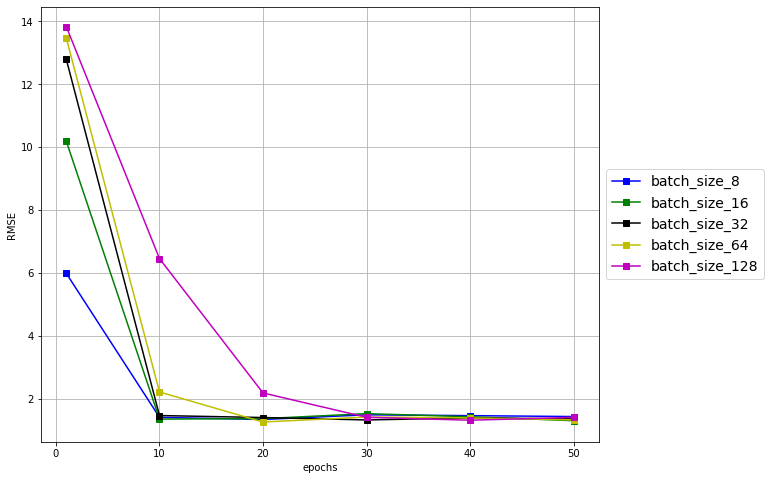

In [17]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [18]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 1.255
min MAPE = 0.820%
optimum epochs = 20
optimum batch_size = 64


# Final model

In [24]:
# Split train_cv into x and y
x_train, y_train = create_dataset(train, N_opt)
x_train = np.reshape(x_train,(x_train.shape[0], 1 , x_train.shape[1]))

# Split test into x and y
x_test, y_test = create_dataset(test, N_opt)
x_test = np.reshape(x_test,(x_test.shape[0], 1 , x_test.shape[1]))

model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],N_opt)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))
#
## compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)
## train model
model.fit(x_train, y_train, epochs=epochs_opt, batch_size=batch_size_opt, verbose=2)
    
# save model
model.save('optimal_lstm.h5')
# predict
# Do prediction
train_predict = model.predict(x_train)
# est = inverse transform
#print("est.shape = " + str(est.shape))

# invert standardize data
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
    
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
# print('RMSE = %.2f RMSE' % (trainScore))

#from sklearn.metrics import mean_absolute_percentage_error
# Calculate MAPE
mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])*100

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

Epoch 1/20
10/10 - 0s - loss: 0.7630
Epoch 2/20
10/10 - 0s - loss: 0.6731
Epoch 3/20
10/10 - 0s - loss: 0.5650
Epoch 4/20
10/10 - 0s - loss: 0.4409
Epoch 5/20
10/10 - 0s - loss: 0.2941
Epoch 6/20
10/10 - 0s - loss: 0.1848
Epoch 7/20
10/10 - 0s - loss: 0.1381
Epoch 8/20
10/10 - 0s - loss: 0.1195
Epoch 9/20
10/10 - 0s - loss: 0.0766
Epoch 10/20
10/10 - 0s - loss: 0.0855
Epoch 11/20
10/10 - 0s - loss: 0.0655
Epoch 12/20
10/10 - 0s - loss: 0.0599
Epoch 13/20
10/10 - 0s - loss: 0.0570
Epoch 14/20
10/10 - 0s - loss: 0.0519
Epoch 15/20
10/10 - 0s - loss: 0.0526
Epoch 16/20
10/10 - 0s - loss: 0.0539
Epoch 17/20
10/10 - 0s - loss: 0.0625
Epoch 18/20
10/10 - 0s - loss: 0.0548
Epoch 19/20
10/10 - 0s - loss: 0.0485
Epoch 20/20
10/10 - 0s - loss: 0.0533
RMSE on test set = 1.261
MAPE on test set = 0.827%
